<a href="https://colab.research.google.com/github/jwkanggist/EverybodyTensorflow2.0/blob/master/lab4_mlp_clusterincluster_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LAB4 Multi-layer perceptron for cluster in cluster data

목적: 가장 기본적인 classification 문제 인 cluster-in-cluster data classification을 tf2.0을 가지고 풀어본다

In [9]:
# preprocessor parts

from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt

from datetime import datetime

from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'자동차 관리'
 190625_autodilabel_marco.gslides
'제출서류 (1).zip'
'스크린샷 2019-10-20 오후 4.50.49.png'
'스크린샷 2019-11-12 오후 2.11.09.png'
'2020 회사마일스톤.gsheet'
'기술회의 5_21.pdf'
 asset
'clustering in khan: 19하반기 로드맵.gdoc'
'Colab Notebooks'
 company
'CSD in konkuk'
 csnlbackup
 DeepNol
'네이버 면접  키워드.gdoc'
'아사쿠사에서 재우기가 현주에게.gdoc'
'알렉스 요청.gsheet'
'성수동 맛집.gsheet'
 제주도휴가계획.gsheet
 jay_uiuc_recommand_letter_19dec.docx
 jay_uiuc_recommand_letter_19dec.gdoc
 jejucamp2018_admin
 job
 kaa-thres-logic
 kaa-thres-logic.png
 knowledge_chunk
 legacy
 MoTLAB
 oliruco
'paper summary template.gdoc'
 phD_thesis
 platfarm_backup
 private
 seminar_materials
'구매커피콩리스트 (since June2019).gsheet'
 soundlly
'stocks analysis.gsheet'
 trips
 제출서류.zip


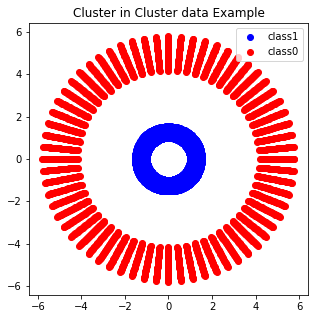

In [49]:
xsize  = 2
ysize  = 2

data = pd.read_csv('/content/drive/My Drive/seminar_materials/TensorFlow Lecture/KIT2020/data/clusterincluster_N5000.csv')
data.columns=['xdata1','xdata2','tdata']
permutation_index = np.random.permutation(data.index)
permutated_data = data.reindex(permutation_index)
permutated_data.columns=['xdata1','xdata2','tdata']

x_data = np.zeros([permutated_data.xdata1.size,xsize])
x_data[:,0] = permutated_data.xdata1.values
x_data[:,1] = permutated_data.xdata2.values

t_data = np.zeros([permutated_data.tdata.size,ysize])
t_data[:,0] = permutated_data.tdata.values
t_data[:,1] = np.invert(permutated_data.tdata.values) + 2


total_size = permutated_data.xdata1.size
training_size = int(np.floor(permutated_data.xdata1.size * 0.8))
validation_size = total_size - training_size



# data dividing
x_train = x_data[0:training_size,:]
y_train = t_data[0:training_size,:]

x_test = x_data[training_size:-1,:]
y_test = t_data[training_size:-1,:]

# #data plot
hfig1= plt.figure(1,figsize=[5,5])
plt.scatter(data.xdata1.values[0:int(data.xdata1.size/2)],\
            data.xdata2.values[0:int(data.xdata1.size/2)], \
            color='b',label='class1')
plt.scatter(data.xdata1.values[int(data.xdata1.size/2)+2:-1],\
            data.xdata2.values[int(data.xdata1.size/2)+2:-1], \
            color='r',label='class0')
plt.title('Cluster in Cluster data Example')
plt.legend()

plt.show()

In [0]:
# model building and training setting part

# Network Parameters
n_hidden_1 = 7 # 1st layer number of neurons
n_hidden_2 = 5 # 2nd layer number of neurons
num_input = xsize   # two-dimensional input X = [1x2]
num_classes = ysize # 2 class

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(n_hidden_1, activation='relu'),
  tf.keras.layers.Dense(n_hidden_2, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
# model training and evaluation part
training_epochs = 100
batch_size = 128

model.fit(x_train, y_train, epochs=training_epochs,batch_size=128)
model.evaluate(x_test,  y_test, verbose=2)

Train on 3996 samples
Epoch 1/100
3996/3996 [==============================] - 1s 167us/sample - loss: 0.7894 - accuracy: 0.4174
Epoch 2/100
3996/3996 [==============================] - 0s 13us/sample - loss: 0.7053 - accuracy: 0.3028
Epoch 3/100
3996/3996 [==============================] - 0s 14us/sample - loss: 0.6538 - accuracy: 0.4695
Epoch 4/100
3996/3996 [==============================] - 0s 11us/sample - loss: 0.6111 - accuracy: 0.6602
Epoch 5/100
3996/3996 [==============================] - 0s 12us/sample - loss: 0.5695 - accuracy: 0.7550
Epoch 6/100
3996/3996 [==============================] - 0s 11us/sample - loss: 0.5258 - accuracy: 0.8338
Epoch 7/100
3996/3996 [==============================] - 0s 12us/sample - loss: 0.4783 - accuracy: 0.9124
Epoch 8/100
3996/3996 [==============================] - 0s 13us/sample - loss: 0.4238 - accuracy: 0.9637
Epoch 9/100
3996/3996 [==============================] - 0s 11us/sample - loss: 0.3577 - accuracy: 0.9907
Epoch 10/100
3996/3996 

[0.00032919494558605395, 1.0]

<Figure size 360x360 with 0 Axes>

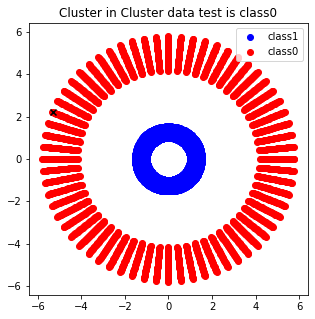

In [52]:
# prediction 

plt.figure(1,figsize=(5,5))
test_input = x_test[0,:]
test_output = y_test[0,:]
pred_y = model.predict(test_input.reshape([1,xsize]))

hfig2= plt.figure(2,figsize=[5,5])
plt.scatter(data.xdata1.values[0:int(data.xdata1.size/2)],\
            data.xdata2.values[0:int(data.xdata1.size/2)], \
            color='b',label='class1')
plt.scatter(data.xdata1.values[int(data.xdata1.size/2)+2:-1],\
            data.xdata2.values[int(data.xdata1.size/2)+2:-1], \
            color='r',label='class0')
plt.scatter(test_input[0],test_input[1],color='k',marker='x')
plt.title('Cluster in Cluster data test is class%s' % pred_y.argmax())
plt.legend()

plt.show()
